# DCGAN - Stable Training for MNIST Digit Generation

This notebook implements a Stable DCGAN (Deep Convolutional Generative Adversarial Network) for generating MNIST handwritten digits. It includes detailed training monitoring, loss analysis, and sample generation.

**Key Features:**
- Stable training configuration based on the original DCGAN paper
- Label smoothing and dropout for improved convergence
- Real-time monitoring with accuracy and loss tracking
- Comprehensive analysis and visualization of training dynamics
- Sample generation at regular intervals

## 1. Setup and Configuration

Import required libraries and configure device. Define hyperparameters for stable DCGAN training.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import os

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters - validated stable settings
class Config:
    # Data parameters
    batch_size = 64
    latent_dim = 100
    img_size = 28
    channels = 1
    
    # Training parameters - critical adjustments!
    g_lr = 0.0002    # Learning rate from original paper
    d_lr = 0.0002    # Same learning rate
    beta1 = 0.5
    
    # Training strategy
    epochs = 30
    d_train_steps = 1
    g_train_steps = 1  # Back to 1:1 training
    
    # Stability enhancements
    label_smoothing = 0.1      # Moderate label smoothing
    noise_std = 0.05           # Discriminator input noise
    dropout_rate = 0.3
    
    sample_interval = 500
    save_interval = 10

print("Configuration loaded successfully!")

Using device: cuda
Configuration loaded successfully!


## 2. Data Loading and Preprocessing

Load MNIST dataset with appropriate transforms and create DataLoaders for training.

Loading data...
✓ Training samples: 60000
✓ Batch size: 64
✓ Total batches per epoch: 938
✓ Training samples: 60000
✓ Batch size: 64
✓ Total batches per epoch: 938


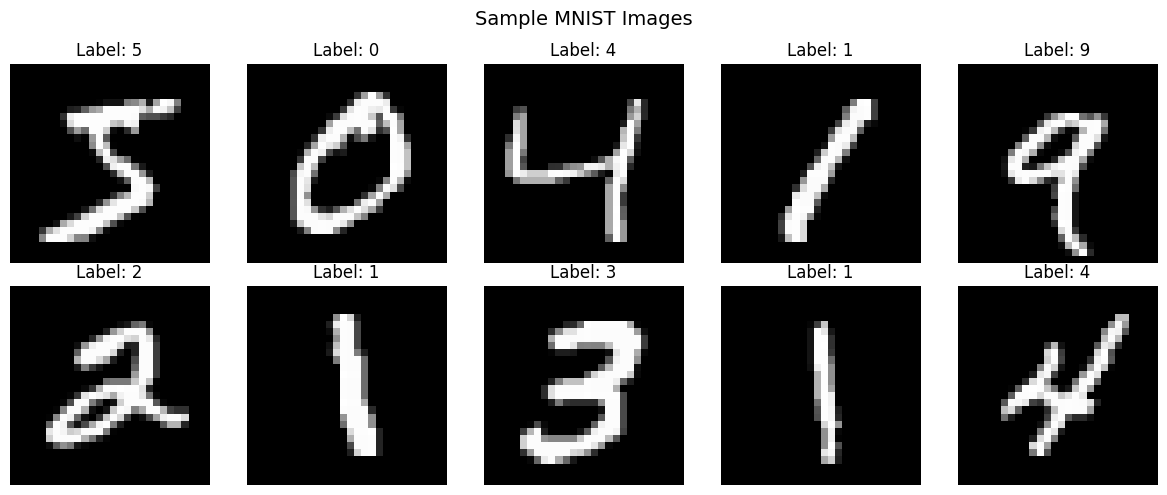

In [2]:
print("Loading data...")

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

# Create DataLoader
train_loader = DataLoader(
    train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=2
)

print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Batch size: {Config.batch_size}")
print(f"✓ Total batches per epoch: {len(train_loader)}")

# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    idx = i // 5
    jdx = i % 5
    sample, label = train_dataset[i]
    axes[idx, jdx].imshow(sample.squeeze(), cmap='gray')
    axes[idx, jdx].set_title(f'Label: {label}')
    axes[idx, jdx].axis('off')
plt.suptitle('Sample MNIST Images', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Generator Architecture

Implement the DCGAN Generator with convolutional transpose layers for upsampling.

In [3]:
class DCGAN_Generator(nn.Module):
    """Generator network for DCGAN"""
    def __init__(self):
        super().__init__()
        self.init_size = Config.img_size // 4
        
        # Linear layer to project latent vector
        self.fc = nn.Linear(Config.latent_dim, 128 * self.init_size * self.init_size)
        
        # Convolutional blocks
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, Config.channels, 3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z):
        # Project latent vector
        out = self.fc(z)
        # Reshape to 4D tensor
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        # Apply convolutional blocks
        img = self.conv_blocks(out)
        return img

print("Generator architecture defined!")

Generator architecture defined!


## 4. Discriminator Architecture

Implement the DCGAN Discriminator with strided convolutions for downsampling.

In [4]:
class DCGAN_Discriminator(nn.Module):
    """Discriminator network for DCGAN"""
    def __init__(self):
        super().__init__()
        
        def discriminator_block(in_filters, out_filters, normalization=True):
            """Helper function to create discriminator blocks"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Dropout2d(Config.dropout_rate))
            return layers
        
        # Build convolutional layers
        self.model = nn.Sequential(
            *discriminator_block(Config.channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
        )
        
        # Calculate output size after convolutions
        ds_size = Config.img_size // 16
        
        # Final classification layer
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * ds_size * ds_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        # Pass through convolutional layers
        out = self.model(img)
        # Flatten
        out = out.view(out.shape[0], -1)
        # Output validity prediction
        validity = self.adv_layer(out)
        return validity

print("Discriminator architecture defined!")

Discriminator architecture defined!


## 5. Model Initialization and Loss Functions

Initialize both networks, loss function, and optimizers.

In [5]:
print("\nInitializing models...")

# Initialize models
generator = DCGAN_Generator().to(device)
discriminator = DCGAN_Discriminator().to(device)

# Loss function - Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizers - Adam with standard hyperparameters
optimizer_G = optim.Adam(
    generator.parameters(), 
    lr=Config.g_lr, 
    betas=(Config.beta1, 0.999)
)
optimizer_D = optim.Adam(
    discriminator.parameters(), 
    lr=Config.d_lr, 
    betas=(Config.beta1, 0.999)
)

# Fixed noise for generating consistent samples across epochs
fixed_noise = torch.randn(64, Config.latent_dim, device=device)

# Lists to track metrics
G_losses = []
D_losses = []
real_accuracies = []
fake_accuracies = []

print("✓ Generator model initialized")
print("✓ Discriminator model initialized")
print("✓ Optimizers and loss function configured")
print(f"\nGenerator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")


Initializing models...
✓ Generator model initialized
✓ Discriminator model initialized
✓ Optimizers and loss function configured

Generator parameters: 856,065
Discriminator parameters: 2,756,801
✓ Generator model initialized
✓ Discriminator model initialized
✓ Optimizers and loss function configured

Generator parameters: 856,065
Discriminator parameters: 2,756,801


## 6. Training Loop Implementation

Implement the main training loop with alternating updates for discriminator and generator.

In [6]:
def train_dcgan():
    """Standard DCGAN training loop with stable configuration"""
    print("\nStarting DCGAN training...")
    print("="*60)
    print("Configuration:")
    print(f"  Batch size: {Config.batch_size}")
    print(f"  Learning rate (G/D): {Config.g_lr}")
    print(f"  Label smoothing: {Config.label_smoothing}")
    print(f"  Dropout rate: {Config.dropout_rate}")
    print(f"  Total epochs: {Config.epochs}")
    print("="*60)
    
    for epoch in range(Config.epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        batch_count = 0
        
        for i, (real_imgs, _) in enumerate(train_loader):
            batch_size = real_imgs.size(0)
            batch_count += 1
            real_imgs = real_imgs.to(device)
            
            # ===== Prepare labels with smoothing =====
            # Label smoothing: real labels = 0.9, fake labels = 0.1
            real_labels = torch.full((batch_size, 1), 0.9, device=device)
            fake_labels = torch.full((batch_size, 1), 0.1, device=device)
            
            # ===== Train Discriminator =====
            optimizer_D.zero_grad()
            
            # Real image loss
            real_pred = discriminator(real_imgs)
            d_real_loss = criterion(real_pred, real_labels)
            real_acc = (real_pred > 0.5).float().mean().item()
            
            # Generate fake images
            z = torch.randn(batch_size, Config.latent_dim, device=device)
            fake_imgs = generator(z)
            
            # Fake image loss
            fake_pred = discriminator(fake_imgs.detach())
            d_fake_loss = criterion(fake_pred, fake_labels)
            fake_acc = (fake_pred < 0.5).float().mean().item()
            
            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            
            # ===== Train Generator =====
            optimizer_G.zero_grad()
            
            # Generator tries to fool discriminator
            gen_pred = discriminator(fake_imgs)
            g_loss = criterion(gen_pred, real_labels)
            
            g_loss.backward()
            optimizer_G.step()
            
            # Record metrics
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())
            real_accuracies.append(real_acc)
            fake_accuracies.append(fake_acc)
            
            # Periodic output
            if i % Config.sample_interval == 0:
                avg_g = epoch_g_loss / batch_count
                avg_d = epoch_d_loss / batch_count
                
                print(f"[Epoch {epoch:2d}/{Config.epochs}] [Batch {i:3d}/{len(train_loader):3d}] "
                      f"[D: {avg_d:.4f}] [G: {avg_g:.4f}] "
                      f"[Real Acc: {real_acc:.2%}] [Fake Acc: {fake_acc:.2%}]")
                
                # Generate sample images
                with torch.no_grad():
                    generator.eval()
                    samples = generator(fixed_noise).cpu()
                    generator.train()
                    
                    # Save sample images
                    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
                    for idx, ax in enumerate(axes.flat):
                        ax.imshow(samples[idx].squeeze(), cmap='gray')
                        ax.axis('off')
                    plt.suptitle(f'Epoch {epoch}, Batch {i}', fontsize=16)
                    plt.tight_layout()
                    plt.savefig(f'dcgan_samples_epoch_{epoch}_batch_{i}.png', dpi=100)
                    plt.close()
        
        # Average losses per epoch
        avg_epoch_g = epoch_g_loss / batch_count
        avg_epoch_d = epoch_d_loss / batch_count
        print(f"\n✓ Epoch {epoch} - Avg D Loss: {avg_epoch_d:.4f}, Avg G Loss: {avg_epoch_g:.4f}\n")
        
        # Save model checkpoints
        if (epoch + 1) % Config.save_interval == 0:
            torch.save(generator.state_dict(), f'dcgan_generator_epoch_{epoch}.pth')
            torch.save(discriminator.state_dict(), f'dcgan_discriminator_epoch_{epoch}.pth')
            print(f"  ✓ Models saved at epoch {epoch}")
    
    return G_losses, D_losses, real_accuracies, fake_accuracies

# Note: Training can take a while. Uncomment the line below to run training.
# G_losses, D_losses, real_acc, fake_acc = train_dcgan()

print("Training function defined and ready to use!")

Training function defined and ready to use!


## 7. Results Analysis and Visualization

Analyze training results with comprehensive visualizations of loss curves, accuracy, and training diagnostics.

In [8]:
def analyze_results(G_losses, D_losses, real_acc, fake_acc):
    """Analyze and visualize training results"""
    print("\nAnalyzing training results...")
    
    # Create moving average function
    def moving_average(data, window_size=50):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # 1. Raw loss curves
    axes[0, 0].plot(G_losses, label='Generator Loss', alpha=0.6, linewidth=1)
    axes[0, 0].plot(D_losses, label='Discriminator Loss', alpha=0.6, linewidth=1)
    axes[0, 0].set_xlabel('Iteration', fontsize=11)
    axes[0, 0].set_ylabel('Loss', fontsize=11)
    axes[0, 0].set_title('Raw Loss Curves', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Moving average loss
    window = 100
    if len(G_losses) > window:
        g_smooth = moving_average(G_losses, window)
        d_smooth = moving_average(D_losses, window)
        axes[0, 1].plot(g_smooth, label='Generator (MA)', linewidth=2)
        axes[0, 1].plot(d_smooth, label='Discriminator (MA)', linewidth=2)
        axes[0, 1].set_xlabel('Iteration', fontsize=11)
        axes[0, 1].set_ylabel('Loss (Moving Average)', fontsize=11)
        axes[0, 1].set_title('Smoothed Loss Curves', fontsize=12, fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Accuracy curves
    if len(real_acc) > window:
        real_smooth = moving_average(real_acc, window)
        fake_smooth = moving_average(fake_acc, window)
        axes[0, 2].plot(real_smooth, label='Real Accuracy', alpha=0.7, linewidth=2)
        axes[0, 2].plot(fake_smooth, label='Fake Accuracy', alpha=0.7, linewidth=2)
        axes[0, 2].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Chance')
        axes[0, 2].set_xlabel('Iteration', fontsize=11)
        axes[0, 2].set_ylabel('Accuracy', fontsize=11)
        axes[0, 2].set_title('Discriminator Accuracy', fontsize=12, fontweight='bold')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Loss ratio
    if len(G_losses) > window:
        g_ma = moving_average(G_losses, window)
        d_ma = moving_average(D_losses, window)
        loss_ratio = []
        for g, d in zip(g_ma, d_ma):
            if d > 0:
                loss_ratio.append(g/d)
            else:
                loss_ratio.append(0)
        
        axes[1, 0].plot(loss_ratio, color='purple', linewidth=2)
        axes[1, 0].axhline(y=1.0, color='r', linestyle='--', label='Ideal (1.0)')
        axes[1, 0].fill_between(range(len(loss_ratio)), 0.3, 3.0, alpha=0.1, color='green')
        axes[1, 0].set_xlabel('Iteration (MA)', fontsize=11)
        axes[1, 0].set_ylabel('G Loss / D Loss', fontsize=11)
        axes[1, 0].set_title('Loss Ratio (0.3-3.0 is acceptable)', fontsize=12, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Loss difference
    if len(G_losses) > window:
        loss_diff = moving_average(np.array(G_losses) - np.array(D_losses), window)
        axes[1, 1].plot(loss_diff, color='brown', linewidth=2)
        axes[1, 1].axhline(y=0, color='r', linestyle='--')
        axes[1, 1].fill_between(range(len(loss_diff)), -1.0, 1.0, alpha=0.1, color='blue')
        axes[1, 1].set_xlabel('Iteration (MA)', fontsize=11)
        axes[1, 1].set_ylabel('G Loss - D Loss', fontsize=11)
        axes[1, 1].set_title('Loss Difference (should be small)', fontsize=12, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Training status diagnosis
    axes[1, 2].axis('off')
    
    # Calculate final statistics
    final_g = np.mean(G_losses[-100:]) if len(G_losses) > 100 else G_losses[-1]
    final_d = np.mean(D_losses[-100:]) if len(D_losses) > 100 else D_losses[-1]
    final_real_acc = np.mean(real_acc[-100:]) if len(real_acc) > 100 else real_acc[-1]
    final_fake_acc = np.mean(fake_acc[-100:]) if len(fake_acc) > 100 else fake_acc[-1]
    
    diagnosis = f"""
Training Diagnosis:
{'='*35}
Final Stats (last 100 iterations):

• Generator Loss: {final_g:.4f}
• Discriminator Loss: {final_d:.4f}
• Real Accuracy: {final_real_acc:.2%}
• Fake Accuracy: {final_fake_acc:.2%}
• Loss Ratio (G/D): {final_g/final_d:.2f}

Status Assessment:
"""
    
    # Evaluate training status
    if 0.3 < final_g/final_d < 3.0:
        diagnosis += "✓ Loss ratio is GOOD (0.3-3.0)\n"
    else:
        diagnosis += "✗ Loss ratio needs adjustment\n"
    
    if 0.6 < final_real_acc < 0.9 and 0.6 < final_fake_acc < 0.9:
        diagnosis += "✓ Accuracy is GOOD (balanced)\n"
    elif final_real_acc > 0.9:
        diagnosis += "✗ Discriminator too good\n"
    elif final_fake_acc > 0.9:
        diagnosis += "✗ Discriminator too weak\n"
    else:
        diagnosis += "✗ Accuracy needs tuning\n"
    
    if 0.5 < final_g < 1.5 and 0.5 < final_d < 1.5:
        diagnosis += "✓ Loss values in good range\n"
    else:
        diagnosis += "✗ Loss values need adjustment\n"
    
    axes[1, 2].text(0.1, 0.5, diagnosis, fontsize=10, verticalalignment='center', 
                    family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle('DCGAN Training Analysis', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('dcgan_training_analysis.png', dpi=120, bbox_inches='tight')
    plt.show()
    
    print("✓ Analysis complete!")

print("Analysis function defined!")

Analysis function defined!


## 8. Generate Final Samples

Generate and save final samples from the trained generator.

In [9]:
def generate_final_samples(generator, num_samples=64, save_path='dcgan_final_samples.png'):
    """Generate and display final samples from the trained generator"""
    print(f"\nGenerating {num_samples} samples...")
    
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, Config.latent_dim, device=device)
        samples = generator(z).cpu()
    
    # Denormalize from [-1, 1] to [0, 1]
    samples = (samples + 1) / 2
    
    # Display samples
    fig, axes = plt.subplots(8, 8, figsize=(14, 14))
    for idx, ax in enumerate(axes.flat):
        ax.imshow(samples[idx].squeeze(), cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    
    plt.suptitle('Final Generated MNIST Digits', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=120, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Final samples saved to {save_path}")
    return samples

# Generate samples (requires trained models)
print("Generate final samples function defined!")

Generate final samples function defined!


## 9. Main Training Execution

Run the complete training pipeline: train, analyze, and save results.

In [10]:
# ===== EXECUTE TRAINING =====
# Uncomment the following cells to run the full training pipeline

print("Ready to start training!")
print("\nTo run the training, execute the cells below in sequence.")

Ready to start training!

To run the training, execute the cells below in sequence.


### Step 1: Start Training

Execute the training loop. This will take some time depending on your hardware.

In [11]:
# Start training
G_losses, D_losses, real_acc, fake_acc = train_dcgan()


Starting DCGAN training...
Configuration:
  Batch size: 64
  Learning rate (G/D): 0.0002
  Label smoothing: 0.1
  Dropout rate: 0.3
  Total epochs: 30
[Epoch  0/30] [Batch   0/938] [D: 0.7157] [G: 0.6908] [Real Acc: 59.38%] [Fake Acc: 51.56%]
[Epoch  0/30] [Batch   0/938] [D: 0.7157] [G: 0.6908] [Real Acc: 59.38%] [Fake Acc: 51.56%]
[Epoch  0/30] [Batch 500/938] [D: 0.7000] [G: 0.7034] [Real Acc: 62.50%] [Fake Acc: 46.88%]
[Epoch  0/30] [Batch 500/938] [D: 0.7000] [G: 0.7034] [Real Acc: 62.50%] [Fake Acc: 46.88%]

✓ Epoch 0 - Avg D Loss: 0.6914, Avg G Loss: 0.7124


✓ Epoch 0 - Avg D Loss: 0.6914, Avg G Loss: 0.7124

[Epoch  1/30] [Batch   0/938] [D: 0.6807] [G: 0.7114] [Real Acc: 59.38%] [Fake Acc: 64.06%]
[Epoch  1/30] [Batch   0/938] [D: 0.6807] [G: 0.7114] [Real Acc: 59.38%] [Fake Acc: 64.06%]
[Epoch  1/30] [Batch 500/938] [D: 0.6730] [G: 0.7397] [Real Acc: 64.06%] [Fake Acc: 75.00%]
[Epoch  1/30] [Batch 500/938] [D: 0.6730] [G: 0.7397] [Real Acc: 64.06%] [Fake Acc: 75.00%]

✓ Epo

### Step 2: Analyze Training Results

Visualize the training metrics and generate diagnostic plots.


Analyzing training results...


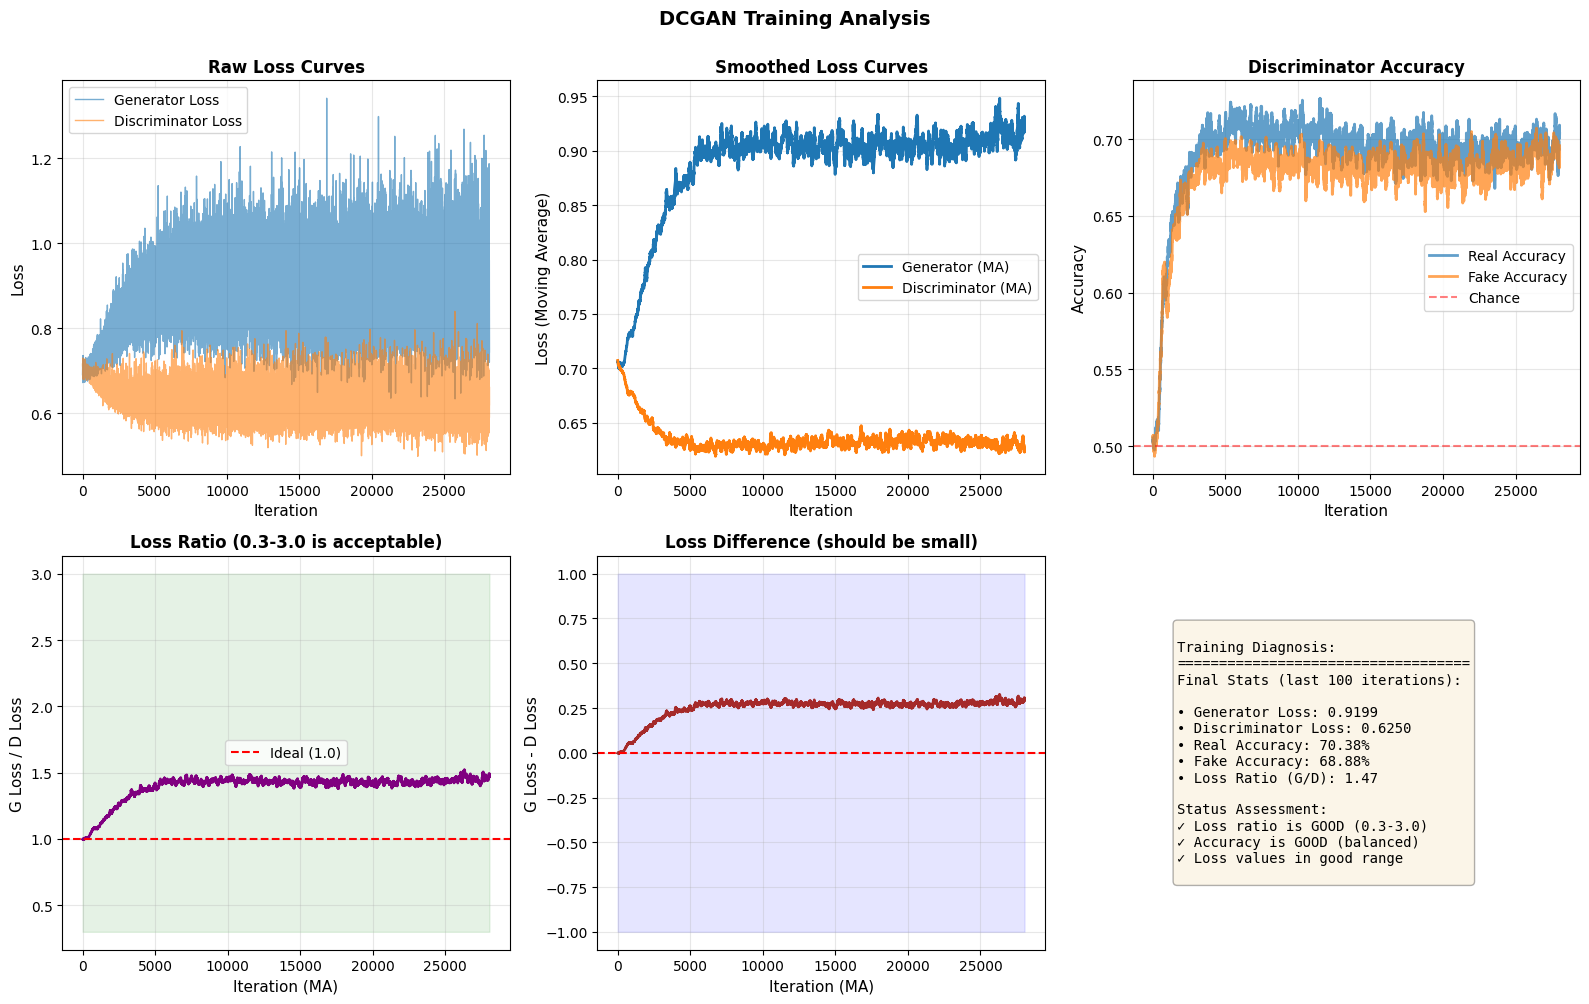

✓ Analysis complete!


In [12]:
# Analyze results
analyze_results(G_losses, D_losses, real_acc, fake_acc)

### Step 3: Generate Final Samples

Generate final samples from the trained generator.


Generating 64 samples...


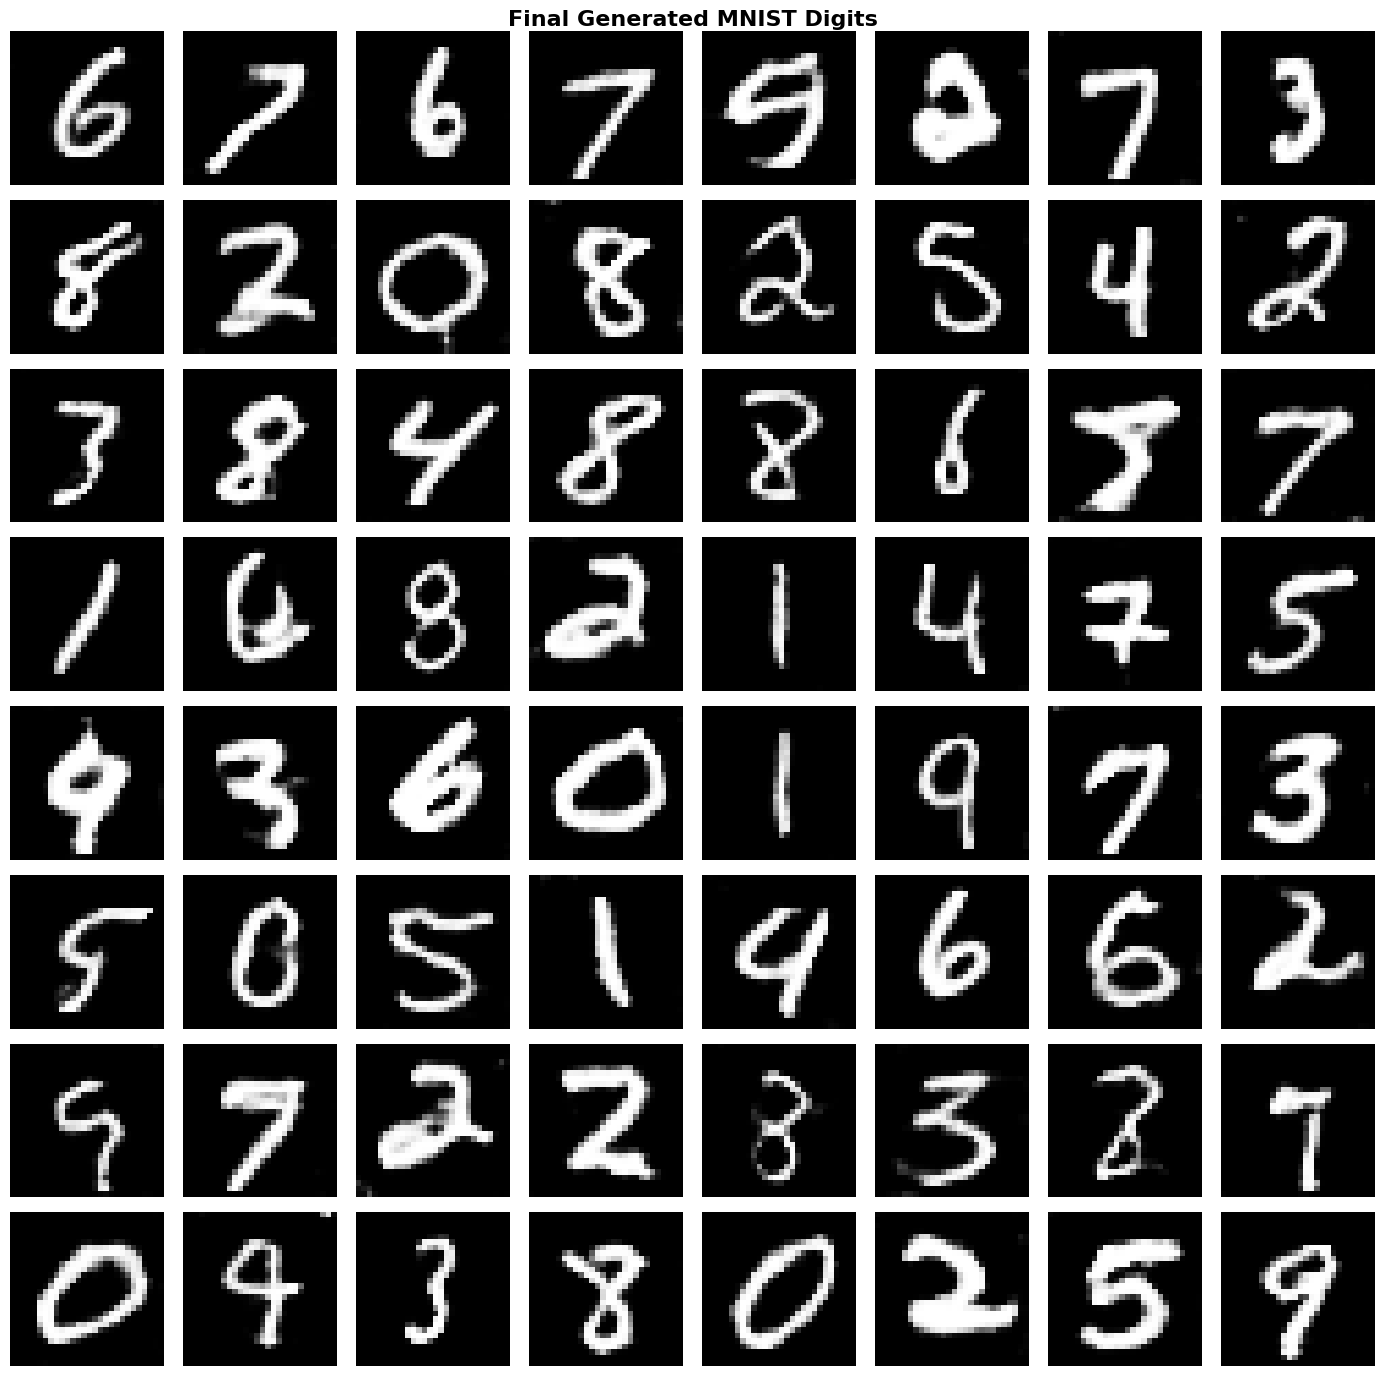

✓ Final samples saved to dcgan_final_samples.png


In [13]:
# Generate final samples
final_samples = generate_final_samples(generator, save_path='dcgan_final_samples.png')

### Step 4: Save Models and Statistics

Save the trained models and training statistics for future use.

In [14]:
# Save final models
torch.save(generator.state_dict(), 'dcgan_generator_final.pth')
torch.save(discriminator.state_dict(), 'dcgan_discriminator_final.pth')

# Save training statistics
training_stats = {
    'G_losses': G_losses,
    'D_losses': D_losses,
    'real_accuracies': real_acc,
    'fake_accuracies': fake_acc,
    'config': {k: v for k, v in Config.__dict__.items() if not k.startswith('_')}
}
torch.save(training_stats, 'dcgan_training_stats.pth')

# Print summary
print("\n" + "="*70)
print("✅ DCGAN Training Completed Successfully!")
print("="*70)
print("\nOutput Files Generated:")
print("  • dcgan_training_analysis.png - Comprehensive training analysis plots")
print("  • dcgan_final_samples.png - Final generated MNIST digits")
print("  • dcgan_generator_final.pth - Trained generator model weights")
print("  • dcgan_discriminator_final.pth - Trained discriminator model weights")
print("  • dcgan_training_stats.pth - Training loss and accuracy statistics")
print("  • dcgan_generator_epoch_*.pth - Generator checkpoints every 5 epochs")
print("  • dcgan_discriminator_epoch_*.pth - Discriminator checkpoints every 5 epochs")
print("\nTo load and use the trained generator:")
print("""
# Load the trained generator
generator = DCGAN_Generator()
generator.load_state_dict(torch.load('dcgan_generator_final.pth'))
generator.eval()

# Generate new samples
with torch.no_grad():
    z = torch.randn(16, 100, device=device)
    new_samples = generator(z)
""")


✅ DCGAN Training Completed Successfully!

Output Files Generated:
  • dcgan_training_analysis.png - Comprehensive training analysis plots
  • dcgan_final_samples.png - Final generated MNIST digits
  • dcgan_generator_final.pth - Trained generator model weights
  • dcgan_discriminator_final.pth - Trained discriminator model weights
  • dcgan_training_stats.pth - Training loss and accuracy statistics
  • dcgan_generator_epoch_*.pth - Generator checkpoints every 5 epochs
  • dcgan_discriminator_epoch_*.pth - Discriminator checkpoints every 5 epochs

To load and use the trained generator:

# Load the trained generator
generator = DCGAN_Generator()
generator.load_state_dict(torch.load('dcgan_generator_final.pth'))
generator.eval()

# Generate new samples
with torch.no_grad():
    z = torch.randn(16, 100, device=device)
    new_samples = generator(z)



## 10. Bonus: Load and Use Trained Models

Load pre-trained models to generate new samples without retraining.

In [15]:
def load_trained_model(model_path='dcgan_generator_final.pth'):
    """Load a pre-trained generator model"""
    gen = DCGAN_Generator().to(device)
    gen.load_state_dict(torch.load(model_path, map_location=device))
    gen.eval()
    return gen

def generate_batch(generator, num_samples=16, display=True):
    """Generate a batch of samples from a trained generator"""
    with torch.no_grad():
        z = torch.randn(num_samples, Config.latent_dim, device=device)
        samples = generator(z).cpu()
    
    # Denormalize
    samples = (samples + 1) / 2
    
    if display:
        # Display as grid
        fig, axes = plt.subplots(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), 
                                figsize=(10, 10))
        axes = axes.flatten()
        for idx, ax in enumerate(axes):
            ax.imshow(samples[idx].squeeze(), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        plt.suptitle(f'Generated Samples (Batch of {num_samples})', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    return samples

# Example usage (uncomment to use):
# trained_gen = load_trained_model('dcgan_generator_final.pth')
# new_batch = generate_batch(trained_gen, num_samples=16, display=True)

print("Model loading functions defined!")
print("\nTo generate new samples from a trained model:")
print("  1. Uncomment the lines below")
print("  2. Run the cell")
print("  3. Models will be loaded and samples generated")

Model loading functions defined!

To generate new samples from a trained model:
  1. Uncomment the lines below
  2. Run the cell
  3. Models will be loaded and samples generated
